# Processing, curation and filtering of 100 most sequenced, smallest, and largest organisms data

### Preparation

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gmean
from Bio import Entrez
import time
import re
from bs4 import BeautifulSoup
import requests

In [2]:
# Interactive matplotlib plot
%matplotlib notebook

### Data tables

Data collected manually from the literature by Luis González de Salceda. Length and width show (mm) but the actual units are ($\mu m$)

In [3]:
df = pd.read_excel('100_microbes.xlsx')
df.head()

,Organism,All,Sampled,Length (mm),Width (mm),Shape,Reference
0,Salmonella enterica,375417,1,2-5,0.5-1.5,rod,"Andino, A., & Hanning, I. (2015). Salmonella e..."
1,Escherichia coli,142518,1,1-2,0.5,rod,National Research Council (US) Steering Group ...
2,Campylobacter jejuni,48171,0,0.5-2.5,NaN,sphere/spiral,"Rodrigues, R.C., Pocheron, AL., Hernould, M. e..."
3,Listeria monocytogenes,44033,0,0.5-2,0.5-4,rod,"Abdollah Jamshidi, Tayebeh Zeinali, ""Significa..."
4,Staphylococcus aureus,25850,0,1,NaN,sphere,"Monteiro, J. M., Fernandes, P. B., Vaz, F., Pe..."


In [4]:
# Number of records
df.shape

(100, 7)

In [5]:
# Drop records without lenght AND width
df = df.dropna(subset = ['Length (mm)', 'Width (mm)'], how = 'all')
df.shape

(54, 7)

In [6]:
# If shape is sphere, then length is the same as width
for i, row in df.iterrows():
    if re.findall('[Ss]phere', str(row['Shape'])):
        df.at[i, 'Width (mm)'] = df.at[i, 'Length (mm)']

In [7]:
df[df['Width (mm)'].isna()].shape

(5, 7)

In [8]:
df[df['Length (mm)'].isna()].shape

(0, 7)

In [9]:
# Drop records with no width
df.dropna(subset = ['Width (mm)'], inplace = True)

In [10]:
df.shape

(49, 7)

### Check entries already sampled in BacDive

In [11]:
sampled = df[df['Sampled'] == 1].copy()
sampled.shape

(9, 7)

In [12]:
# Load data frame of BacDive entries
df_bac = pd.read_csv('data.tsv', sep = '\t', index_col = 0)
df_bac.shape

(4908, 11)

In [13]:
# Check if cell size is similar
sampled['length_bac'] = None
sampled['width_bac'] = None
sampled['shape_bac'] = None
for i, row in sampled.iterrows():
    hit = df_bac[df_bac['species'].str.contains(row['Organism'])]
    if hit.shape[0] != 0:
        sampled.at[i, 'length_bac'] = hit['length'].to_string().split(' ')[-1]
        sampled.at[i, 'width_bac'] = hit['width'].to_string().split(' ')[-1]
        sampled.at[i, 'shape_bac'] = hit['shape'].to_string().split(' ')[-1]

In [14]:
sampled

,Organism,All,Sampled,Length (mm),Width (mm),Shape,Reference,length_bac,width_bac,shape_bac
0,Salmonella enterica,375417,1,2-5,0.5-1.5,rod,"Andino, A., & Hanning, I. (2015). Salmonella e...",2.0,0.866025,NaN
1,Escherichia coli,142518,1,1-2,0.5,rod,National Research Council (US) Steering Group ...,2.85,0.65,rod-shaped
12,Pseudomonas aeruginosa,8648,1,1.5-3,0.5-0.8,rod,"Iglewski BH. Pseudomonas. In: Baron S, editor....",7.415443,0.658787,rod-shaped
19,Legionella pneumophila,3373,1,2-25,0.5,rod,Rodgers F. G. (1979). Ultrastructure of Legion...,1.55,0.7,ovoid-shaped
20,Helicobacter pylori,2937,1,5,0.5,S-shape,"O'Rourke J, Bode G. Morphology and Ultrastruct...",3.535534,0.707107,rod-shaped
33,Stenotrophomonas maltophilia,1040,1,1.5,0.5,rod,"Norberto J. Palleroni, John F. Bradbury: Steno...",1.5,0.5,rod-shaped
86,Cutibacterium acnes,308,1,0.8-0.9,0.4-0.5,rod,"C. F. P. K. Scholz, Mogens: The natural histor...",0.848528,0.447214,coccus-shaped
90,Lactobacillus delbrueckii,293,1,2-9,0.5-0.8,rod,"Teixeira, P. LACTOBACILLUS | Lactobacillus del...",6.25,0.5,rod-shaped
91,Alistipes onderdonkii,292,1,0.5-3,0.2-0.5,rod,"Barberan A, Caceres Velazquez H, Jones S, Fier...",1.224745,0.316228,rod-shaped


**Note that <font color = 'red'>*Escherichia coli, Pseudomonas aeruginosa, Legionella pneumophila, Helicobacter pylori*</font> have different cell sizes according to BacDive and articles retrieved from PubMed.**

<font color = 'red'> I will drop these records for now... and keep the results from BacDive. </font>

In [15]:
df = df.drop([1, 12, 19, 20, 0, 33, 86, 90, 91])

## Data from the smallest and largest microbes

In [16]:
df1 = pd.read_excel('Small_and_giant_microbes.xlsx')
df1.head()

,Small Microbes,Length (mm),Width (mm),Shape,Genome,Reference
0,Pelagibacter ubique,0.37-0.89,0.12-0.20,rod,Full,"Rappé, M., Connon, S., Vergin, K. et al. Culti..."
1,Mycoplasma genitalium,0.3,NaN,pear,Full,"Helle Friis Svenstrup, Jens Fedder, Joanna Abr..."
2,Mycoplasma gallisepticum,0.2,NaN,pear,Full,"Atalla, H., Lysnyansky, I., Raviv, Y., & Rotte..."
3,Nanoarchaeum equitans,0.4,NaN,sphere,Full,"Fenchel, T., King, G. M., & Blackburn, T. H. (..."
4,Prochlorococcus,0.5-0.7,NaN,sphere,Full,"Partensky, F., Hess, W. R., & Vaulot, D. (1999..."


In [17]:
# Number of records
df1.shape

(14, 6)

Correct data for *Thiomargarita namibiensis*.

In [18]:
df1.at[13, 'Length (mm)'] = '100-300'

In [19]:
df1.loc[13]

Small Microbes                            Thiomargarita namibiensis
Length (mm)                                                 100-300
Width (mm)                                                      NaN
Shape                                                        sphere
Genome                                                          NaN
Reference         N., S. H., T., B., G., F. T., Hernández, M. M....
Name: 13, dtype: object

Add a new entry: [largest bacterium ever discovered](https://www.science.org/content/article/largest-bacterium-ever-discovered-has-unexpectedly-complex-cells?utm_source=Nature+Briefing&utm_campaign=f3a6c61808-briefing-dy-20220224&utm_medium=email&utm_term=0_c9dfd39373-f3a6c61808-43769453). Data from cell H, Table S2 of [preprint](https://www.biorxiv.org/content/10.1101/2022.02.16.480423v1). 

In [20]:
df1 = df1.append({'Small Microbes': 'Thiomargarita magnifica', 'Length (mm)': '9720',
                'Width (mm)': '30', 'Shape': 'rod', 'Genome': 'NaN', 
                 'Reference': 'https://doi.org/10.1101/2022.02.16.480423'}, ignore_index = True)

In [21]:
df1

,Small Microbes,Length (mm),Width (mm),Shape,Genome,Reference
0,Pelagibacter ubique,0.37-0.89,0.12-0.20,rod,Full,"Rappé, M., Connon, S., Vergin, K. et al. Culti..."
1,Mycoplasma genitalium,0.3,NaN,pear,Full,"Helle Friis Svenstrup, Jens Fedder, Joanna Abr..."
2,Mycoplasma gallisepticum,0.2,NaN,pear,Full,"Atalla, H., Lysnyansky, I., Raviv, Y., & Rotte..."
3,Nanoarchaeum equitans,0.4,NaN,sphere,Full,"Fenchel, T., King, G. M., & Blackburn, T. H. (..."
4,Prochlorococcus,0.5-0.7,NaN,sphere,Full,"Partensky, F., Hess, W. R., & Vaulot, D. (1999..."
5,Spirochaeta plicatilis,80-250,0.75,spiral,NaN,"Schulz‐Vogt, H.N., Angert, E.R. and Garcia‐Pic..."
6,Cristispira anodontae,44-88,0.8-1.2,spiral,NaN,"Spirochaeta anodontae Keysselitz, Arb. a. d. k..."
7,Cristispira pinnae,10-60,0.5-3.0,spiral,NaN,"Spirochaete pinnae Gonder, Cent. f. Bakt., I A..."
8,Treponema azotonutricium,10-12,0.2-0.3,spiral,Full,"R., G. J., R., L. J., & A., B. J. (2004). Desc..."
9,Treponema primitia,3-7,0.2,spiral,Full,"R., G. J., R., L. J., & A., B. J. (2004). Desc..."


In [22]:
# Drop records without lenght AND width
df1 = df1.dropna(subset = ['Length (mm)', 'Width (mm)'], how = 'all')
df1.shape

(15, 6)

Let's assume that pear-shaped bacteria can be approximated to a sphere

In [23]:
# If shape is sphere, then length is the same as width
for i, row in df1.iterrows():
    if re.findall('([Ss]phere)|(pear)', str(row['Shape'])):
        df1.at[i, 'Width (mm)'] = df1.at[i, 'Length (mm)']

In [24]:
# Drop records with no width
df1 = df1.dropna(subset = ['Width (mm)'])

In [25]:
df1.shape

(14, 6)

Check if records are contained in BacDive

In [26]:
for i, row in df1.iterrows():
    hit = df_bac[df_bac['species'].str.contains(row['Small Microbes'])]
    if hit.shape[0] != 0:
        print('Hit')

**None of the smalles or largest microbes are contained in the BacDIve dataset**

### Cell size data

In [27]:
# Drop columns irrelevant columns
df.drop(columns = ['All', 'Sampled'], inplace = True)
df1.drop(columns = ['Genome'], inplace = True)

Unit of length and widht in $\mu m$

In [28]:
# Rename columns
df.rename(columns = {'Organism': 'species', 'Length (mm)': 'length', 'Width (mm)': 'width', 'Reference': 'reference'}, inplace = True)
df1.rename(columns = {'Small Microbes': 'species', 'Length (mm)': 'length', 'Width (mm)': 'width', 'Reference': 'reference'}, inplace = True)

In [29]:
# Join datasets
df_ = pd.concat([df, df1])

In [30]:
df_.shape

(54, 5)

Standardize length and width values:

- For ranges (e.g., 4-8), take geometric mean
- For minimum / maximum values, take boundary.
- There are some exceptions. The following code deals with exceptions.

In [31]:
def size_to_num(size):
    """
    Function that converts a size string into a float number.
    Inputs:
        size: str contining the size
    Outputs:
        s: float containing the standardized size
    """
    if '-' in size:
        if len(size.split('-')) == 2:
            return np.sqrt(np.prod([float(x) for x in size.split('-')]))
        elif len(size.split('-')) > 2:
            return gmean([float(x) for x in size.split('-')])
    elif size.startswith(('>', '<')):
        return float(size[1:])
    else:
        return float(size)

In [32]:
df_.head()

,species,length,width,Shape,reference
2,Campylobacter jejuni,0.5-2.5,0.5-2.5,sphere/spiral,"Rodrigues, R.C., Pocheron, AL., Hernould, M. e..."
3,Listeria monocytogenes,0.5-2,0.5-4,rod,"Abdollah Jamshidi, Tayebeh Zeinali, ""Significa..."
4,Staphylococcus aureus,1,1,sphere,"Monteiro, J. M., Fernandes, P. B., Vaz, F., Pe..."
5,Streptococcus pneumoniae,0.5-1.25,0.5-1.25,sphere,"Patterson MJ. Streptococcus. In: Baron S, edit..."
6,Campylobacter coli,0.2-0.5,0.2-0.5,sphere/rod,"Lansing M. Prescott, John P. Harley, and Donal..."


In [33]:
df_['length'] = df_['length'].astype(str).apply(size_to_num)
df_['width'] = df_['width'].astype(str).apply(size_to_num)

Ensure that length is greater than or equal to width.

In [34]:
df_[['length', 'width']] = df_[['length', 'width']].apply(
    lambda x: pd.Series([max(x), min(x)]), axis=1)

## Data distribution

<IPython.core.display.Javascript object>


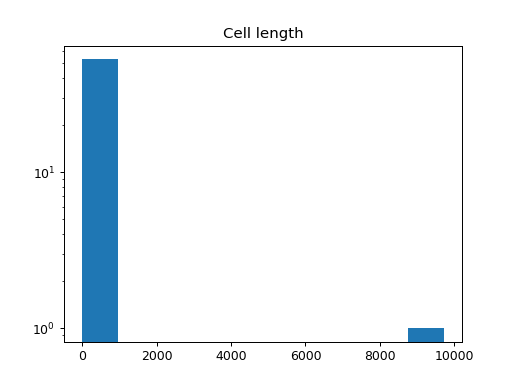

In [35]:
plt.figure()
plt.hist(df_['length'], log=True)
plt.title('Cell length')
plt.show()

<IPython.core.display.Javascript object>


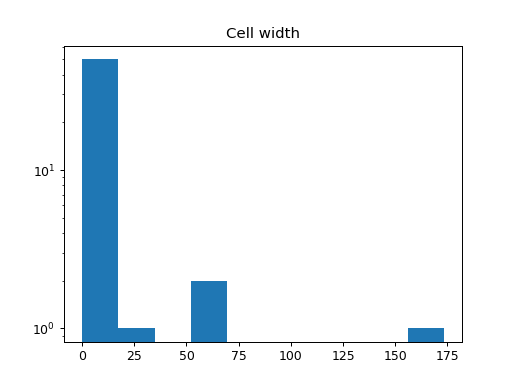

In [36]:
plt.figure()
plt.hist(df_['width'], log=True)
plt.title('Cell width')
plt.show()

### Cell volume and surface area

Second, assume that cells are [capsules](https://en.wikipedia.org/wiki/Capsule_(geometry)).

- Volume: $ V = \pi r^{2} (\frac{4}{3} r + a)$

- Surface area: $ S = 2 \pi r (2r + a) $

In which $a$ = length - width, $r$ = width / 2.

In [37]:
df_['volume'] = np.pi * (df_['width'] / 2) ** 2 * ((4 / 3) * (df_['width'] / 2) + (df_['length'] - df_['width']))

In [38]:
df_['surface'] = 2 * np.pi * (df_['width'] / 2) * (2 * (df_['width'] / 2) + (df_['length'] - df_['width']))

In [39]:
# Set a new index
df_.set_index(np.arange(0, df_.shape[0]), inplace = True)

### Output

In [40]:
df_.shape

(54, 7)

In [41]:
df_.to_csv('data_manually.tsv', sep = '\t')